# Measuring Communication Efficiency and Learnability of Colors using an Information Bottleneck Framework

In [59]:
import pandas as pd
import numpy as np
from ibhelpers import *
from scipy.spatial import distance

In [6]:
# load the data from the World Color Survey
df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
df.columns = ["language", "speaker", "chip", "word"]

## Calculate prior probabilities

For each language, $l$, we can use a frequentist approach (counts) to calculate the observed quantities of $p(w|c,l)$ and $p(c|w,l)$

In [7]:
per_chip_count_df = df.groupby(["language", "chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
total_word_count_df = df.groupby(["language", "chip"]).word.agg(total_words_per_chip="count")

# frequentist probability of a word given chip and language
p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
p_word_chip_language.head(5)

language  chip  word
1         1     F       0.08
                G       0.52
                LB      0.36
                LF      0.04
          2     F       0.60
dtype: float64

In [8]:
per_word_count_df = df.groupby(["language", "word", "chip"]).speaker.agg(individual_count_per_chip_per_word="count")
total_chip_count_df = df.groupby(["language", "word"]).chip.agg(total_chips_per_word="count")

# frequentist probability of a chip given word and language
p_chip_word_language = per_word_count_df["individual_count_per_chip_per_word"] / total_chip_count_df["total_chips_per_word"]
p_chip_word_language.head(5)

language  word  chip
1         F     1       0.001366
                2       0.010246
                4       0.001366
                5       0.011612
                6       0.003415
dtype: float64

## Information Bottleneck

Code taken from Frank (osfstorage)

### Initialise components for optimising IB objective

We need to initialise a joint prior distribution of words and meanings, i.e. `p_wm`, and a corresponding variational joint distribution, i.e. `q0` (q_wm_0).

In [9]:
# number of possible meanings
n_meanings = 330 #TODO: change this with the correct number from WCS
n_words = n_meanings
# to avoid underflow problem
eps = 0.01

q0 = (1 - eps) * np.eye(n_meanings) + eps * np.ones((n_meanings, n_meanings))

the following block is TEMPORARY, should be updated

In [47]:
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)
p_xy = np.random.rand(n_meanings, n_meanings)
p_xy = softmax(p_xy, 0)

In [51]:
q0 = q0 / q0.sum(axis=1, keepdims=True) # q0 initial encoder - can set it to identity
betas = np.array([2.0 ** x for x in np.arange(5, 0, -1)])
focalbeta = 5.3

In [52]:
q, beta, ibscores, qresult, qseq, qseqresults, allqs = fit_ib(p_xy, q0, focalbeta, betas, verbose=1)

32.0:1
16.0:1
8.0:1
4.0:1
2.0:1


In [54]:
allqs

[array([[0.00307904, 0.00304061, 0.00304727, ..., 0.00303542, 0.00302544,
         0.00303891],
        [0.00304315, 0.00307562, 0.00304773, ..., 0.00303163, 0.00302373,
         0.003046  ],
        [0.00304742, 0.00304525, 0.00308016, ..., 0.00303478, 0.00302803,
         0.00304531],
        ...,
        [0.00304801, 0.00304189, 0.00304737, ..., 0.0030681 , 0.00302354,
         0.00304085],
        [0.00304636, 0.00304208, 0.00304902, ..., 0.00303193, 0.00305799,
         0.00304633],
        [0.00303916, 0.00304365, 0.00304554, ..., 0.00302853, 0.00302571,
         0.00307996]]),
 array([[0.00304492, 0.00304208, 0.00304455, ..., 0.00303202, 0.00302371,
         0.00304429],
        [0.00304456, 0.00304242, 0.00304456, ..., 0.00303199, 0.00302368,
         0.00304438],
        [0.00304462, 0.00304214, 0.00304485, ..., 0.00303201, 0.00302373,
         0.00304436],
        ...,
        [0.00304461, 0.0030421 , 0.00304454, ..., 0.00303234, 0.00302367,
         0.00304431],
        [0.0

In [55]:
beta

4.0

In [56]:
ibscores

[(-2760.8860350388386, 19.281396292996824, 0.0),
 (-2760.886330658383, 19.281396509649873, 0.0),
 (-2760.886330701117, 19.281396509683972, 0.0),
 (-2760.886330701119, 19.28139650968398, 0.0),
 (-2760.886330701119, 19.281396509683997, 0.0)]

In [68]:
items = [str(x+1) for x in range(n_meanings)]
columns = ['M'+str(i) for i in items]

# create data frames for plotting and analysis
ib_scores_df = pd.DataFrame(np.array(ibscores), columns = ['rate', 'distortion', 'elen'])
ib_scores_df['beta'] = betas
ib_scores_df['q'] = allqs
ib_scores_df['Wn'] = [mergecols(q).shape[1] for q in ib_scores_df['q']]

# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + columns)

In [69]:
stochSys

,n,rate,distortion,M1,M2,M3,M4,M5,M6,M7,...,M321,M322,M323,M324,M325,M326,M327,M328,M329,M330
0,1.0,-2760.886035,19.281396,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,...,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303


<AxesSubplot:xlabel='rate'>

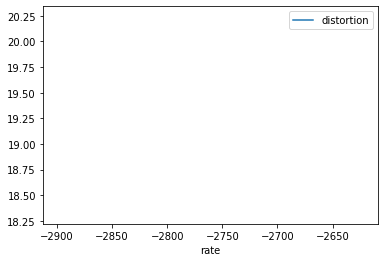

In [66]:
stochSys.cumsum()
stochSys.plot(x="rate", y='distortion')

In [ ]:
items = ['a', 'b', 'c', 'r', 'x', 'y', 'z']

# probabilities from Geoff's dissertation from Google N-grams (1985)
allp =  np.array([0.1034, 0.0795, 0.1839, 0.6183, 0.0074, 0.0048, 0.0028])
pastprops = allp[0:3]/np.sum(allp[0:3])
futprops = allp[4:7]/np.sum(allp[4:7])
duboisprobs = np.array([27.4, 47.5, 25.1]) # From Twitter Corpus
duboisprobs = duboisprobs / np.sum(duboisprobs)
p_x = np.concatenate( [duboisprobs[0] * pastprops, duboisprobs[[1]], duboisprobs[2]*futprops ] )
p_x = p_x / np.sum(p_x)

eps = 0.01
q0 = (1 - eps) * np.eye(7) + eps * np.ones((7, 7))

kap = 0.5
lam = 0.1

p_xGy = np.array(
    [[1, kap, kap ** 2, lam * kap ** 2, lam ** 2 * kap ** 2, lam ** 2 * kap ** 3, lam ** 2 * kap ** 4],
     [kap, 1, kap, lam * kap, lam ** 2 * kap, lam ** 2 * kap ** 2, lam ** 2 * kap ** 3],
     [kap ** 2, kap, 1, lam, lam ** 2, lam ** 2 * kap, lam ** 2 * kap ** 2],
     [lam * kap ** 2, lam * kap, lam, 1, lam, lam * kap, lam * kap ** 2],
     [lam ** 2 * kap ** 2, lam ** 2 * kap, lam ** 2, lam, 1, kap, kap ** 2],
     [lam ** 2 * kap ** 3, lam ** 2 * kap ** 2, lam ** 2 * kap, lam * kap, kap, 1, kap],
     [lam ** 2 * kap ** 4, lam ** 2 * kap ** 3, lam ** 2 * kap ** 2, lam * kap ** 2, kap ** 2, kap, 1]])

p_mGs = p_xGy / np.sum(p_xGy, axis=0)
p_xGy = p_xGy / p_xGy.sum(axis=1, keepdims=True)
p_xy = p_xGy * p_x[:, np.newaxis]
p_xy = p_xy / np.sum(p_xy) 

### The Pareto Frontier
Now let's run the Information Bottleneck Method

In [ ]:
# trace out optimal frontier
q0 = q0 / q0.sum(axis=1, keepdims=True) # q0 initial encoder - can set it to identity
betas = np.array([2.0 ** x for x in np.arange(5, 0, -0.001)])
focalbeta = 5.3

q, beta, ibscores, qresult, qseq, qseqresults, allqs = fit_ib(p_xy, q0, focalbeta, betas, verbose=1)

# create data frames for plotting and analysis
ib_scores_df = pandas.DataFrame(np.array(ibscores), columns = ['rate', 'distortion', 'elen'])
ib_scores_df['beta'] = betas
ib_scores_df['q'] = allqs
ib_scores_df['Wn'] = [mergecols(q).shape[1] for q in ib_scores_df['q']]

# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pandas.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + items)


In [ ]:
# compute distance from optimal frontier
def fd(asys, ibscores):
    mind = distance.cdist([[asys['rate'], asys['distortion']]], ibscores[['rate', 'distortion']]).min()
    return mind


def gNID_d(asys, paretoQs, betas, pX):
    mind = np.zeros((len(asys), len(paretoQs)))
    for li in range(len(asys)):
        for qi, q in enumerate(paretoQs):
            mind[li, qi] = gNID(asys.iloc[li]['q'], q, pX)
    return np.argmin(mind, axis=1), np.min(mind, axis=1), betas[np.argmin(mind, axis=1)]

